In [ ]:
from google.colab import files

files.upload()

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mamta1999/cardiovascular-risk-data

  0% 0.00/59.3k [00:00<?, ?B/s]
100% 59.3k/59.3k [00:00<00:00, 23.8MB/s]


In [3]:
! unzip /content/cardiovascular-risk-data.zip

Archive:  /content/cardiovascular-risk-data.zip
  inflating: data_cardiovascular_risk.csv  


In [4]:
#import libraries we gonna need.
import warnings
# Disable all warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
dataframe = pd.read_csv('/content/data_cardiovascular_risk.csv')
dataframe.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [6]:
dataframe.describe()

,id,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,1694.500000,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,978.753033,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,847.250000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,1694.500000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,2541.750000,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,3389.000000,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [7]:
# check the datatypes of our dataset
dataframe.dtypes

id                   int64
age                  int64
education          float64
sex                 object
is_smoking          object
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

*There is a column that make no sense at all which is id column so we have to remove it*

In [8]:
dataframe.drop('id',axis=1,inplace=True)

In [9]:
dataframe.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


we need to extract categorical and numerical columns

In [10]:
def extract_cat_num(dataframe):
    cat_col=[col for col in dataframe.columns if dataframe[col].dtype=='object']
    num_col=[col for col in dataframe.columns if dataframe[col].dtype!='object']
    return cat_col,num_col

In [11]:
cat_col , num_col = extract_cat_num(dataframe)

In [12]:
print(f'Categorical columns are : {cat_col}\nNumerical columns are: {num_col}')

Categorical columns are : ['sex', 'is_smoking']
Numerical columns are: ['age', 'education', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']


Check how many unique values in our categorical data to see if there any dirtines

In [13]:
for col in cat_col:
    print('{} has {} values '.format(col,dataframe[col].unique()))
    print('\n')

sex has ['F' 'M'] values 


is_smoking has ['YES' 'NO'] values 




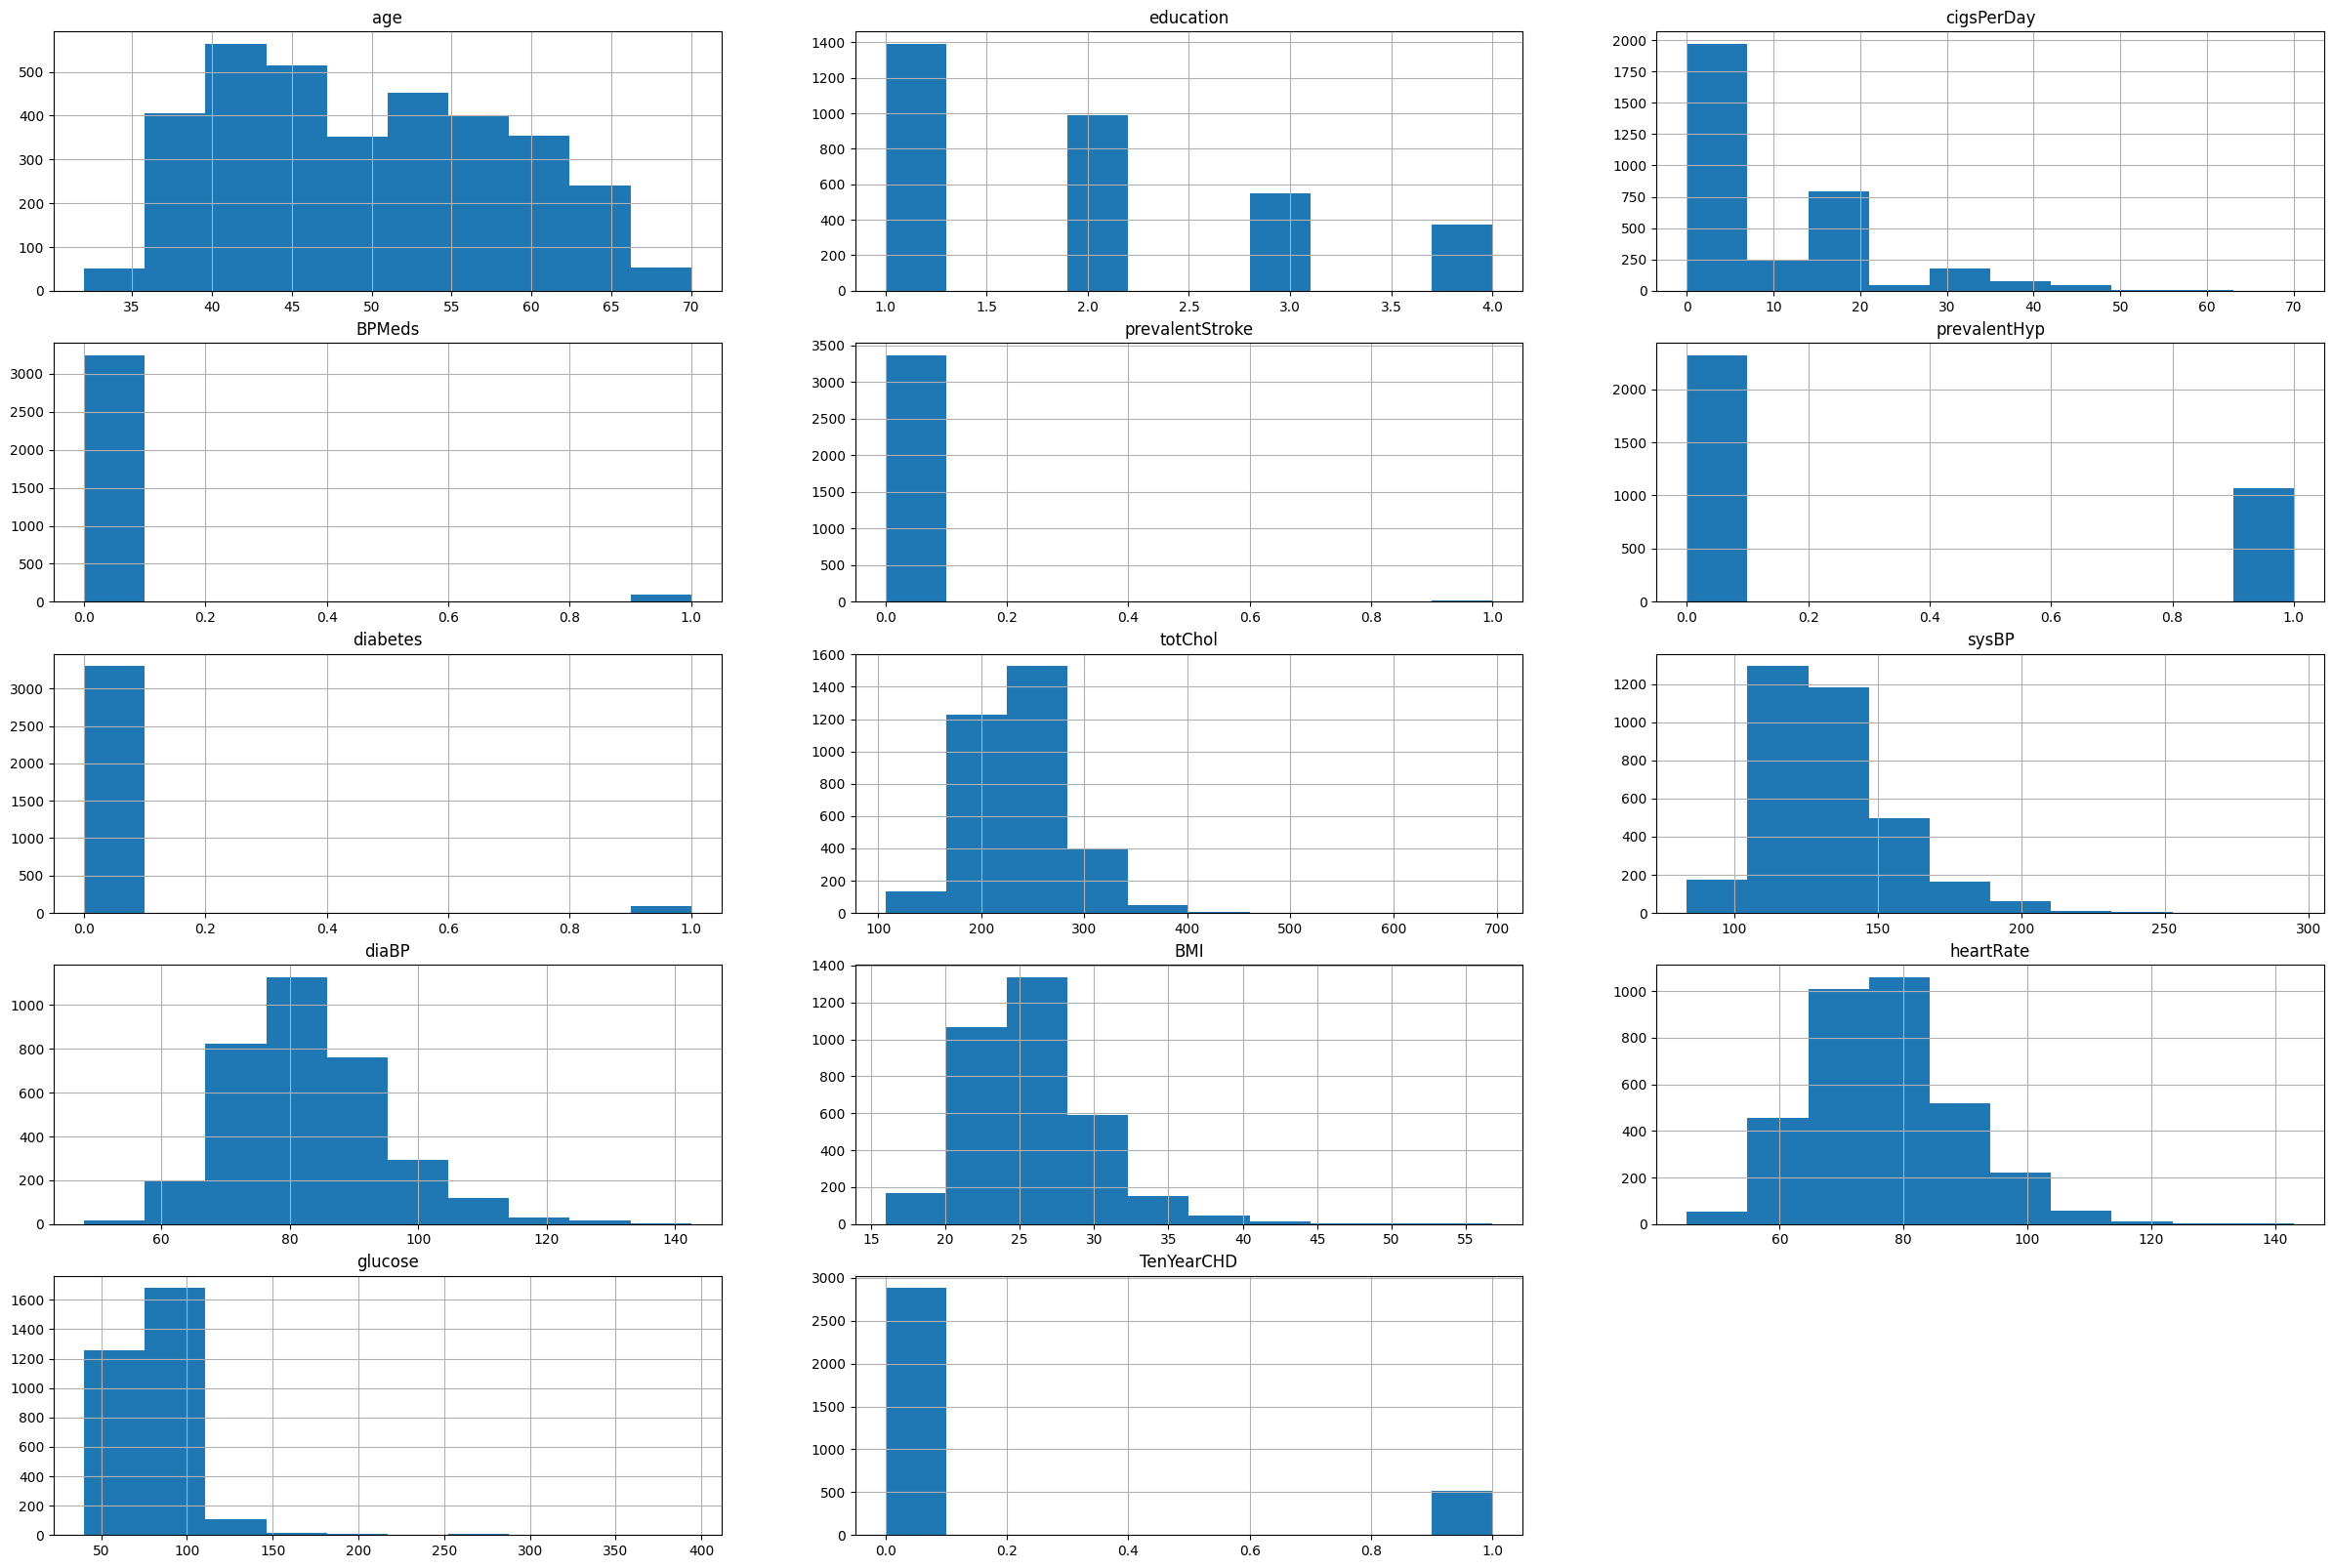

In [14]:
len(num_col)
plt.figure(figsize=(30,20))
for i,feature in enumerate(num_col):
    plt.subplot(5,3,i+1)
    dataframe[feature].hist()
    plt.title(feature)

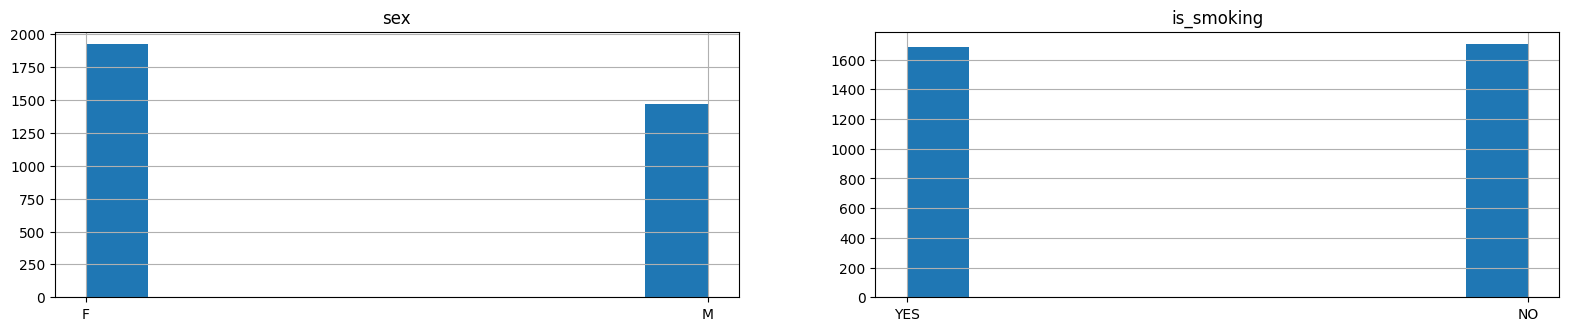

In [15]:
len(cat_col)
plt.figure(figsize=(30,20))
for i,feature in enumerate(cat_col):
    plt.subplot(5,3,i+1)
    dataframe[feature].hist()
    plt.title(feature)

Text(0.5, 1.0, 'target Class')

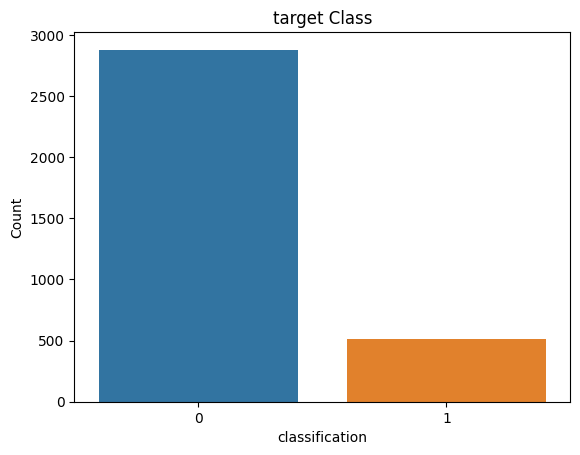

In [16]:
sns.countplot(x='TenYearCHD',data=dataframe)
plt.xlabel("classification")
plt.ylabel("Count")
plt.title("target Class")

Time to check for missing values and handle them

In [17]:
dataframe.isna().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [18]:
def get_unique_values(column_name, dataframe):
    unique_values = dataframe[column_name].unique()
    return unique_values

Our education column is a categorical values 1,2,3,4 so filling missing values in that column with mode would be better than filling it with mean or median

In [19]:
mode_value = dataframe['education'].mode().iloc[0]  # Calculate the mode of the column

dataframe['education'] = dataframe['education'].fillna(mode_value)  # Fill null values with the mode

In [20]:
print('Unique values of cigsPerDay column:', get_unique_values('cigsPerDay',dataframe))

Unique values of cigsPerDay column: [ 3.  0. 10. 20. 30. 35. 40. 15.  9. 60. 17. 25.  5. 43.  7. 50. 19. 18.
  1. 45.  2.  6. nan 11.  8.  4. 14. 16. 23. 13. 12. 70. 38.]


Fill missing values in cigsPerDay column with mean value

In [21]:
dataframe['cigsPerDay'].fillna(dataframe['cigsPerDay'].mean(), inplace=True)

In [22]:
print('Unique values of BPMeds column:', get_unique_values('BPMeds',dataframe))

Unique values of BPMeds column: [ 0. nan  1.]


Since it's obvious that BPMeds are categorical values we will fill the missing values using mode and convert it to int

In [23]:
mode_value_BPMeds = dataframe['BPMeds'].mode().iloc[0]  # Calculate the mode of the column

dataframe['BPMeds'] = dataframe['BPMeds'].fillna(mode_value)  # Fill null values with the mode

In [24]:
dataframe['BPMeds'] = dataframe['BPMeds'].astype(int)

Fill missing Values using Mean

In [25]:
dataframe['totChol'].fillna(dataframe['totChol'].mean(), inplace=True)

In [26]:
dataframe.isna().sum()

age                  0
education            0
sex                  0
is_smoking           0
cigsPerDay           0
BPMeds               0
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              0
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [27]:
dataframe['BMI'].fillna(dataframe['BMI'].median(), inplace=True)

In [28]:
dataframe['glucose'].fillna(dataframe['glucose'].mean(), inplace=True)

In [29]:
dataframe['heartRate'].fillna(dataframe['heartRate'].mean(), inplace=True)

In [30]:
dataframe.isna().sum()

age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [31]:
df_sex_cigs = dataframe[['sex','cigsPerDay']]

In [32]:
grouped_df_sex_cigs = df_sex_cigs.groupby(['sex'],as_index=False).mean()

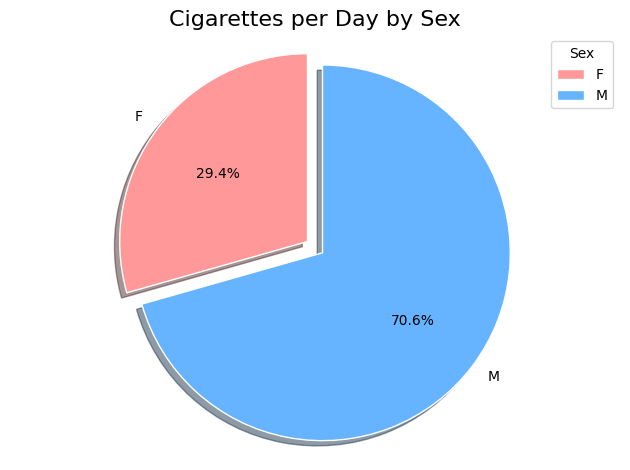

In [33]:
# Data
sex = grouped_df_sex_cigs["sex"]
cigsPerDay = grouped_df_sex_cigs["cigsPerDay"]

# Customization
colors = ['#ff9999', '#66b3ff']  # Specify custom colors
explode = (0.1, 0)  # Explode the first slice
start_angle = 90  # Rotate the pie chart start angle

# Plot
fig, ax = plt.subplots()
ax.pie(cigsPerDay, labels=sex, explode=explode, colors=colors, autopct='%1.1f%%',
       startangle=start_angle, shadow=True, wedgeprops={'edgecolor': 'white'})

# Style
ax.axis('equal')  # Equal aspect ratio ensures a circular pie
plt.title('Cigarettes per Day by Sex', fontsize=16)
plt.legend(title='Sex', loc='upper right')
plt.tight_layout()  # Provides spacing between the plot elements

# Display
plt.show()


<Axes: >

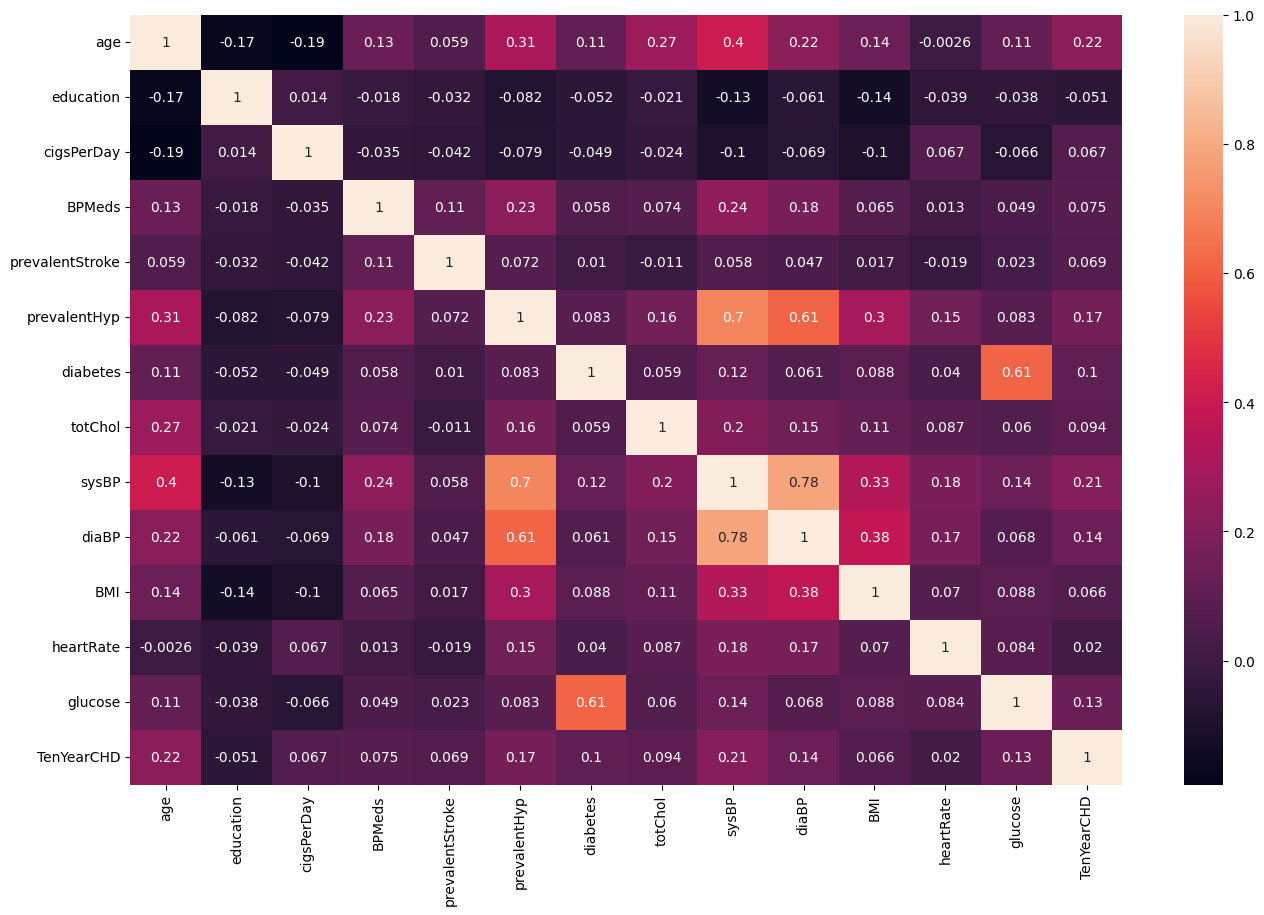

In [34]:
plt.figure(figsize=(16,10))
sns.heatmap(dataframe.corr(), annot=True)

In [35]:
dataframe.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

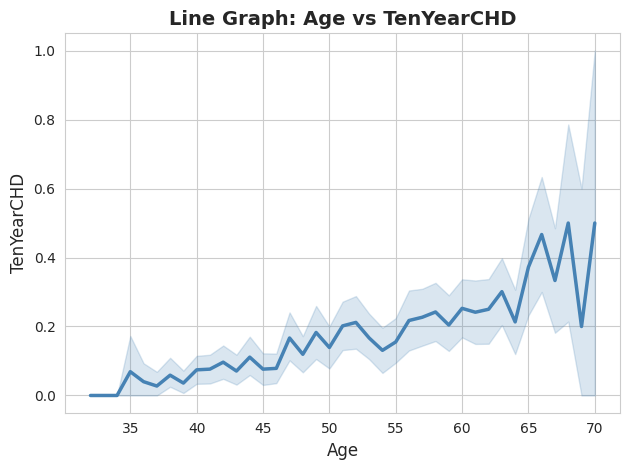

In [36]:
# Set the plot style
sns.set_style('whitegrid')

# Create the line plot
sns.lineplot(data=dataframe, x=dataframe['age'], y=dataframe['TenYearCHD'], linewidth=2.5, color='steelblue')

# Set labels and title
plt.xlabel('Age', fontsize=12)
plt.ylabel('TenYearCHD', fontsize=12)
plt.title('Line Graph: Age vs TenYearCHD', fontsize=14, fontweight='bold')

# Set ticks font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

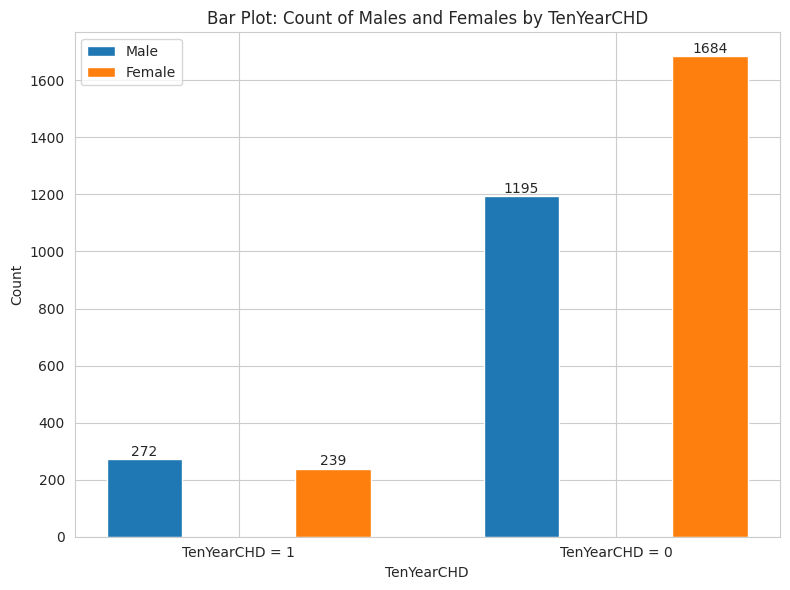

In [37]:
subset_df_target1 = dataframe[dataframe['TenYearCHD'] == 1]  # Filter dataframe for rows where TenYearCHD equals 1
subset_df_target0 = dataframe[dataframe['TenYearCHD'] == 0]  # Filter dataframe for rows where TenYearCHD equals 0

# Count males and females for target=1
male_count_target1 = subset_df_target1[subset_df_target1['sex'] == 'M'].shape[0]
female_count_target1 = subset_df_target1[subset_df_target1['sex'] == 'F'].shape[0]

# Count males and females for target=0
male_count_target0 = subset_df_target0[subset_df_target0['sex'] == 'M'].shape[0]
female_count_target0 = subset_df_target0[subset_df_target0['sex'] == 'F'].shape[0]

# Set style
sns.set_style("whitegrid")

# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))

# Bar width
bar_width = 0.4

# Positions for the bars
male_positions = [0, 2]
female_positions = [1, 3]

# Heights for the bars
male_heights = [male_count_target1, male_count_target0]
female_heights = [female_count_target1, female_count_target0]

# Create the bars
ax.bar(male_positions, male_heights, width=bar_width, label='Male')
ax.bar(female_positions, female_heights, width=bar_width, label='Female')

# Set x-axis ticks and labels
ax.set_xticks([0.5, 2.5])
ax.set_xticklabels(['TenYearCHD = 1', 'TenYearCHD = 0'])

# Set labels and title
ax.set_xlabel('TenYearCHD')
ax.set_ylabel('Count')
ax.set_title('Bar Plot: Count of Males and Females by TenYearCHD')

# Add value labels
for i, v in enumerate(male_heights):
    ax.text(male_positions[i], v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(female_heights):
    ax.text(female_positions[i], v + 0.5, str(v), ha='center', va='bottom')

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

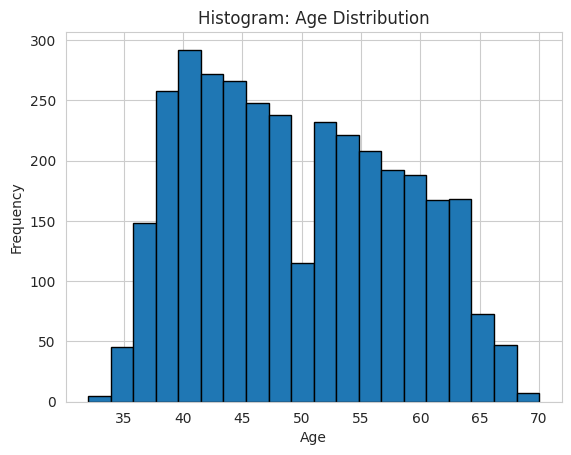

In [38]:
# Set the number of bins for the histogram
num_bins = 20

# Create the histogram plot
plt.hist(dataframe['age'], bins=num_bins, edgecolor='black')

# Set labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram: Age Distribution')

# Show the plot
plt.show()

In [39]:
dataframe['age'].describe()

count    3390.000000
mean       49.542183
std         8.592878
min        32.000000
25%        42.000000
50%        49.000000
75%        56.000000
max        70.000000
Name: age, dtype: float64

In [40]:
# Define the age regions
age_regions = [(30, 40), (41, 50), (51, 60), (61, 70)]

# Create empty dictionaries to store the subsets
age_subsets = {}

# Iterate over the age regions
for region in age_regions:
    # Get the lower and upper bounds of the region
    lower_bound, upper_bound = region

    # Filter the dataframe based on the age range
    subset = dataframe[(dataframe['age'] >= lower_bound) & (dataframe['age'] <= upper_bound)]

    # Add the subset to the dictionary with the region as the key
    age_subsets[region] = subset


In [41]:
for region, subset in age_subsets.items():
    print(f"Age Region: {region}")
    print(subset['TenYearCHD'].value_counts())

Age Region: (30, 40)
0    574
1     30
Name: TenYearCHD, dtype: int64
Age Region: (41, 50)
0    1144
1     139
Name: TenYearCHD, dtype: int64
Age Region: (51, 60)
0    834
1    207
Name: TenYearCHD, dtype: int64
Age Region: (61, 70)
0    327
1    135
Name: TenYearCHD, dtype: int64


In [42]:
for region, subset in age_subsets.items():
    print(f"Age Region: {region}")
    male_count = subset[(subset['sex'] == 'M') & (subset['TenYearCHD'] == 1)].shape[0]
    female_count = subset[(subset['sex'] == 'F') & (subset['TenYearCHD'] == 1)].shape[0]
    print(f"Male Count (TenYearCHD=1): {male_count}")
    print(f"Female Count (TenYearCHD=1): {female_count}")
    print()

Age Region: (30, 40)
Male Count (TenYearCHD=1): 17
Female Count (TenYearCHD=1): 13

Age Region: (41, 50)
Male Count (TenYearCHD=1): 81
Female Count (TenYearCHD=1): 58

Age Region: (51, 60)
Male Count (TenYearCHD=1): 108
Female Count (TenYearCHD=1): 99

Age Region: (61, 70)
Male Count (TenYearCHD=1): 66
Female Count (TenYearCHD=1): 69



In [43]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('TenYearCHD')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [44]:
# Define the feature columns
feature_columns = []

for feature in cat_col:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
        feature, dataframe[feature].unique()
    )
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [45]:
num_col.remove('TenYearCHD')
for feature in num_col:
    numeric_column = feature_column.numeric_column(feature)
    feature_columns.append(numeric_column)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [46]:
# Create the feature layer
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [47]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

2169 train examples
543 validation examples
678 test examples


In [48]:
batch_size = 32 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [49]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10


64/68 [===========================>..] - ETA: 0s - loss: 2.3507 - accuracy: 0.7451

68/68 [==============================] - 1s 5ms/step - loss: 2.2927 - accuracy: 0.7483 - val_loss: 2.8057 - val_accuracy: 0.8250
Epoch 2/10
68/68 [==============================] - 0s 3ms/step - loss: 1.1686 - accuracy: 0.7782 - val_loss: 0.6331 - val_accuracy: 0.8232
Epoch 3/10
68/68 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.7930 - val_loss: 0.5588 - val_accuracy: 0.8343
Epoch 4/10
68/68 [==============================] - 0s 2ms/step - loss: 0.5335 - accuracy: 0.8220 - val_loss: 0.5021 - val_accuracy: 0.7919
Epoch 5/10
68/68 [==============================] - 0s 2ms/step - loss: 0.4368 - accuracy: 0.8428 - val_loss: 0.4954 - val_accuracy: 0.8269
Epoch 6/10
68/68 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.8479 - val_loss: 0.5163 - val_accuracy: 0.8250
Epoch 7/10
68/68 [==============================] - 0s 3ms/step - loss: 0.4296 - accuracy: 0.8492 - val_loss: 0.4853 - val_accuracy: 0.8324
Epoch 8/10
68/68 [=============

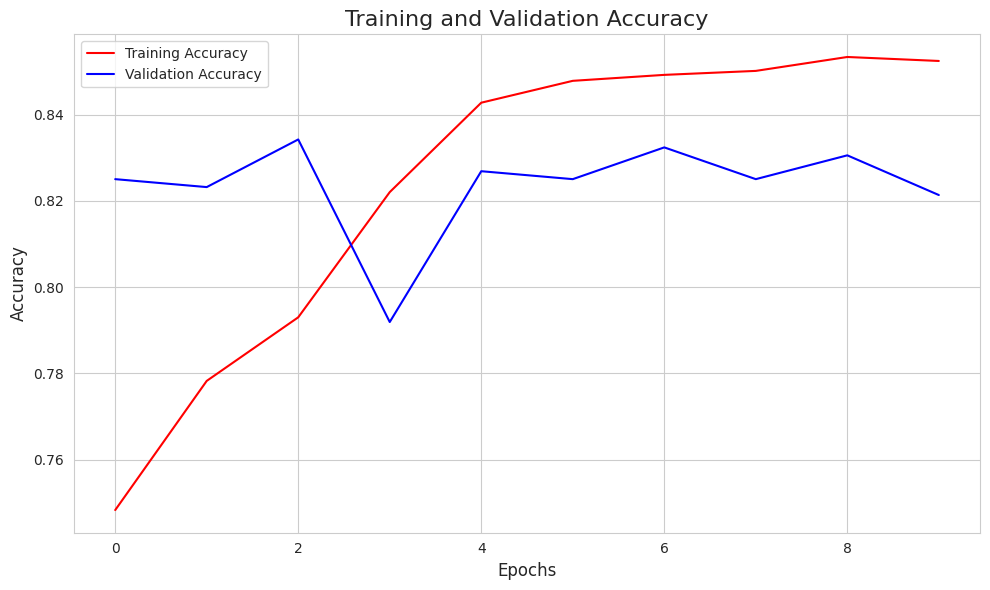

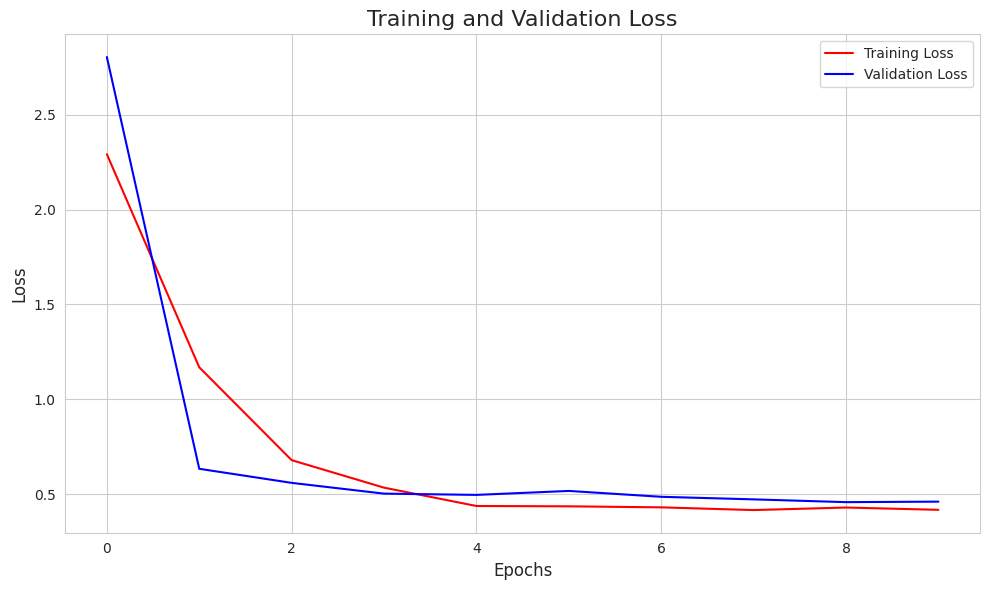

In [50]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [51]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

22/22 [==============================] - 0s 3ms/step - loss: 0.4104 - accuracy: 0.8540
Accuracy 0.8539823293685913
